# Clustering

In [17]:
from sklearn.metrics import silhouette_score

In [18]:
%run ../src/plots.py

In [19]:
%run ../src/utils.py

In [20]:
set_seed()

In [21]:
data = initialize_data()

In [22]:
# Calculate Sentiment Score
data = calculate_sentiment(data)

In [23]:
data_df_tf = vectorize_df(data)

In [24]:
data_df_tf.head()

,title,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_4990,feature_4991,feature_4992,feature_4993,feature_4994,feature_4995,feature_4996,feature_4997,feature_4998,feature_4999
0,Winky D - Propaganda (Official Video),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Donator Calvins - Door Ratovharwa (Mjolo Offic...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,SaintFloew - Fofa Fofa ft. Nutty O (Official M...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Zimbabwe protest I Protests against term exten...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Two Impending decisions in Zimbabwe - prophecy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The value in each box indicates how many times words (or combinations of words) have appeared that, after hashing, fell into that position in the vector.

A feature is a numerical representation of a property of the text that will be used as input for a machine learning model.


In [25]:
num_queries = 3

features, labels = clustering_with_neighbors(data_df_tf, data, user_sentiment="positive", num_queries=num_queries)

In [26]:
# We compute the Silhouette Score and plot it
silhouette_score = silhouette_score(features, labels)

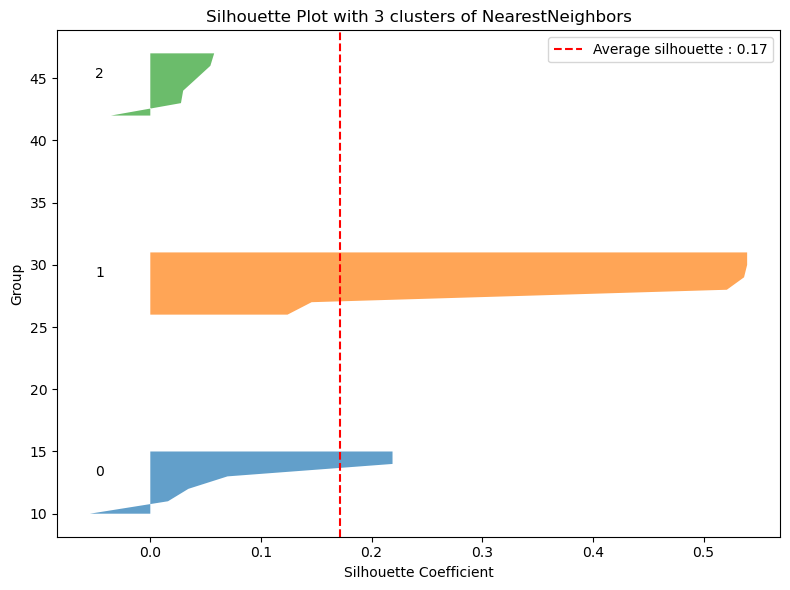

0.17138684450831992

In [27]:
sil_score_plot(silhouette_score, features, labels, 3)

1.Filters by sentiment

2.Use HashingVectorizer to find similarities in the tags.

3.Similar videos ->Nearest Neighbors


In [28]:
canales_cluster, tags_por_canal = channel_based_cluster(data)

In [ ]:
canales_clusters(canales_cluster)

In [ ]:
show_cluster_tags(canales_cluster, tags_por_canal)

Cluster 0: Sports-related videos with international creators like IShowSpeed and Squeezie, featuring some Arabic content.

Cluster 1: Viral short videos focused on humor, TikTok trends, and general entertainment.

Cluster 2: Spanish-language football content, mainly about Real Madrid and player Fede Valverde.

Cluster 3: Minecraft and animation-themed gaming content, with multilingual influence including Arabic.

Cluster 4: International movies and TV dramas, especially Nigerian films and popular "natok" series.

In [31]:
print_reco_target_cluster(canales_cluster, tags_por_canal, 0)

TypeError: string indices must be integers

The system recommends channels that use similar tags in their videos.
It's a content-based approach, using video tags as the channel description.

This compares how similar two channels are based on their tags.Using TF-IDF that stands for "Term Frequency - Inverse Document Frequency."

It is used to weight the most important words in each channel.

-If two channels use similar tags with similar frequencies, they will have a similarity close to 1.0.

-If they share almost no tags, the similarity will be close to 0.0.

# Thematic cluster within the country

In [ ]:
us_canales = thematic_clusters(data, canales_cluster)

plot_thematic_clusters(us_canales)

Visualizes the distribution of YouTube channels in the United States (US, country = "US") based on thematic clusters obtained from their video tags.

They are obtained by applying TF-IDF to the tags (video_tags) of the videos on each channel.

They are then clustered using the KMeans algorithm, which separates the channels into, for example, 5 groups.

In [ ]:
recommend_channels_us(data, us_canales, 0)